In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import pystan
%config InlineBackend.figure_format = 'retina'

In [2]:
full_df = pd.read_csv('data.csv')

In [3]:
# Calculate serve points won
loser_spw_won = full_df['winner_return_points_total'] - full_df['winner_return_points_won']
loser_sp_total = full_df['winner_return_points_total']
losers = full_df['loser']

winner_spw_won = full_df['loser_return_points_total'] - full_df['loser_return_points_won']
winner_spw_total = full_df['loser_return_points_total']
winners = full_df['winner']

In [4]:
winner_frame = pd.DataFrame({'server': winners, 
                             'returner': losers, 
                             'sp_won': winner_spw_won, 
                             'sp_total': winner_spw_total})

loser_frame = pd.DataFrame({'server': losers, 
                            'returner': winners, 
                            'sp_won': loser_spw_won, 
                            'sp_total': loser_sp_total})

combined = pd.concat([winner_frame, loser_frame])

# Drop the index
combined = combined.reset_index(drop=True)

In [5]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

all_players = combined['server'].tolist() + combined['returner'].tolist()

encoder.fit(all_players)

server_ids = encoder.transform(combined['server'].values)
returner_ids = encoder.transform(combined['returner'].values)

In [6]:
model = """
data {
    int<lower=0> num_matches;
    int<lower=0> num_players;
    
    int s_id[num_matches]; // server ids
    int r_id[num_matches]; // returner ids
    
    int spw[num_matches]; // serve points won
    int spt[num_matches]; // serve points total
}
parameters {
    vector[num_players] s; // serving ability
    vector[num_players] r; // returning ability
    real theta_0; // intercept
}
model {
    // priors
    theta_0 ~ normal(0, 1);
    s ~ normal(0, 1);
    r ~ normal(0, 1);
    
    // Likelihood
    spw ~ binomial_logit(spt, s[s_id] - r[r_id] + theta_0);
}
"""

stan_model = pystan.StanModel(model_code=model)

In [7]:
stan_data = {'num_matches': combined.shape[0],
             'num_players': len(encoder.classes_),
             's_id': server_ids + 1,
             'r_id': returner_ids + 1,
             'spw': combined['sp_won'].values.astype(int),
             'spt': combined['sp_total'].values.astype(int)}

fit = stan_model.sampling(data=stan_data)

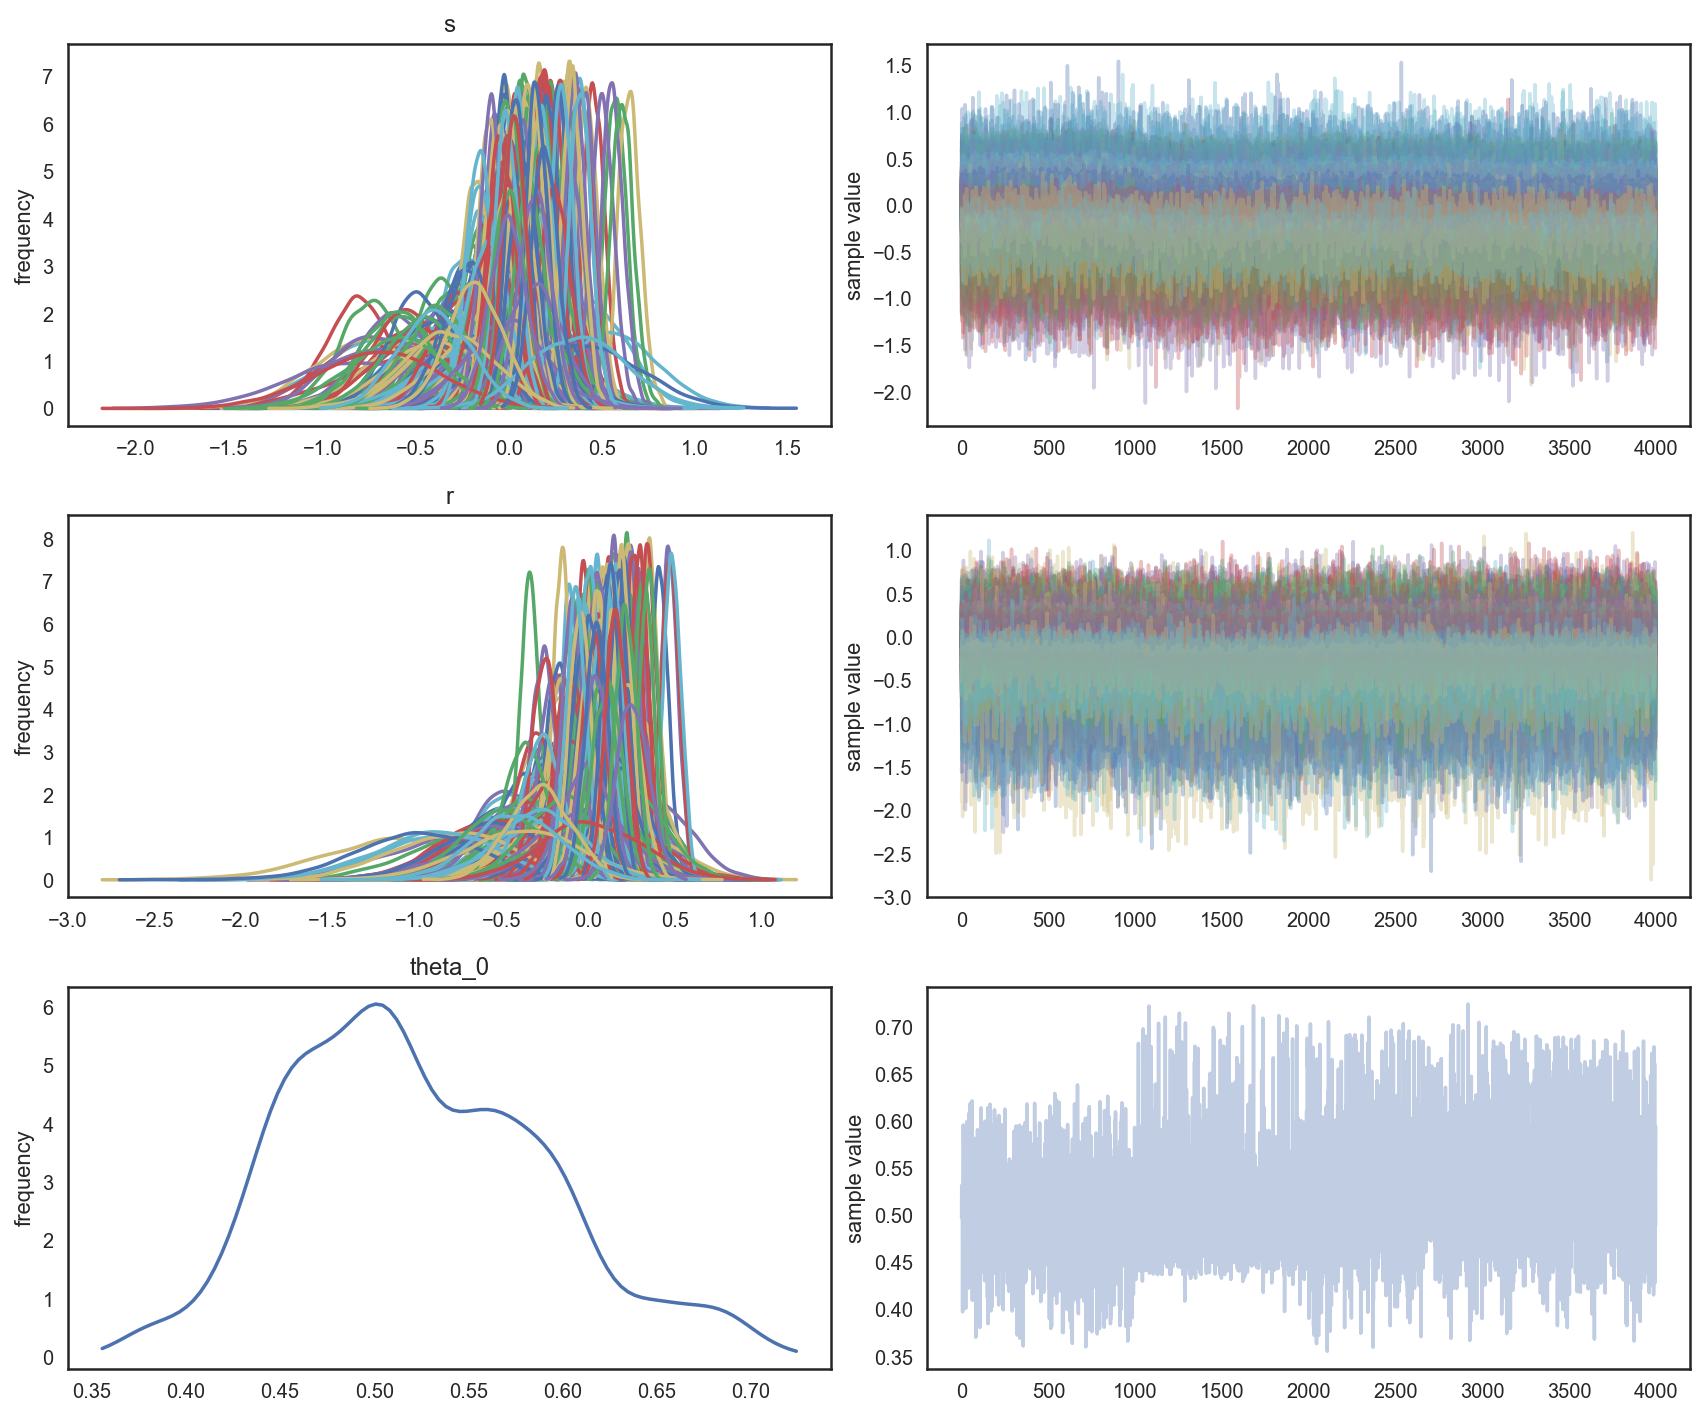

In [8]:
sns.set_style('white')
f = fit.plot()
f.set_size_inches(12, 10)
f.tight_layout()

In [9]:
results = fit.extract()

In [10]:
all_players = encoder.inverse_transform(range(len(encoder.classes_)))

In [11]:
s_means = pd.Series(results['s'].mean(axis=0), index=all_players)
s_means.sort_values(ascending=False).iloc[:10]

John Isner        0.649126
Roger Federer     0.610479
Ivo Karlovic      0.577353
Milos Raonic      0.560516
Jose Statham      0.551818
Nick Kyrgios      0.506549
Ante Pavic        0.464110
Gilles Muller     0.460993
Kevin Anderson    0.424692
Sekou Bangoura    0.418562
dtype: float64

In [12]:
r_means = pd.Series(results['r'].mean(axis=0), index=all_players)
r_means.sort_values(ascending=False).iloc[:10]

Rafael Nadal                   0.485052
Novak Djokovic                 0.472478
Andy Murray                    0.467689
Diego Sebastian Schwartzman    0.407952
Ilya Ivashka                   0.377879
David Goffin                   0.357025
Roger Federer                  0.348486
Kei Nishikori                  0.344707
Richard Gasquet                0.321785
Gael Monfils                   0.321043
dtype: float64

In [13]:
full_df[(full_df['winner'] == 'Jose Statham') | (full_df['loser'] == 'Jose Statham')].winner_return_points_won_pct

2379    0.266667
Name: winner_return_points_won_pct, dtype: float64